In [1]:
from aesthetics import multiplot, invisible
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore", message=".*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence.*")
warnings.filterwarnings("ignore", message=".*Attempting to set identical low and high ylims makes transformation singular; automatically expanding.*")

In [2]:
names = {"al": "AL",
         "ga": "GA",
         "ga_analogs": "GA (Analogs)",
         "spacega": "SpaceGA",
        }
n_names = len(names)

In [3]:
# Use brute force set to determine top score frequencies
levels = {}
for p in ["UROK", "TRYB1", "PARP1"]:
    df = pd.concat([pd.read_parquet(f"../brute/{p}/{i}.parquet")[["scores"]] for i in range(1,101)])
    sample = df.scores.sort_values()
    levels[p] = [sample.iloc[-int(sample.shape[0]/(10**i))] for i in range(1, 7)]

In [4]:
# Collect data from trajectories
combined = []
top = []
for name in names:
    for protein in ["UROK", "TRYB1", "PARP1"]:
        for rep in range(1,4):
            f = f"../{name}/{protein}/{rep}/final.parquet"
            df = pd.read_parquet(f)
            if "s" in df.columns:
                df["Enumerated"] = df.s == 1
            else:
                df["Enumerated"] = True
            df = df[["scores", "Enumerated"]]
            df["Rep."] = str(rep)
            df["Protein"] = protein
            df["Method"] = names[name]
            combined.append(df)
            top.append(df.sort_values("scores", ascending=False).head(100))
combined = pd.concat(combined)
top = {protein: subset for protein, subset in pd.concat(top).groupby("Protein")}
dfs = {protein: subset for protein, subset in combined.groupby("Protein")}

In [5]:
# Define palettes for colors
palette = ["#f9d212", "#80d380", "#fa8072", "#1f90fe"] # For Method colors
palette2 = sns.color_palette("Spectral", 6)[::-1] # For score benchmarks

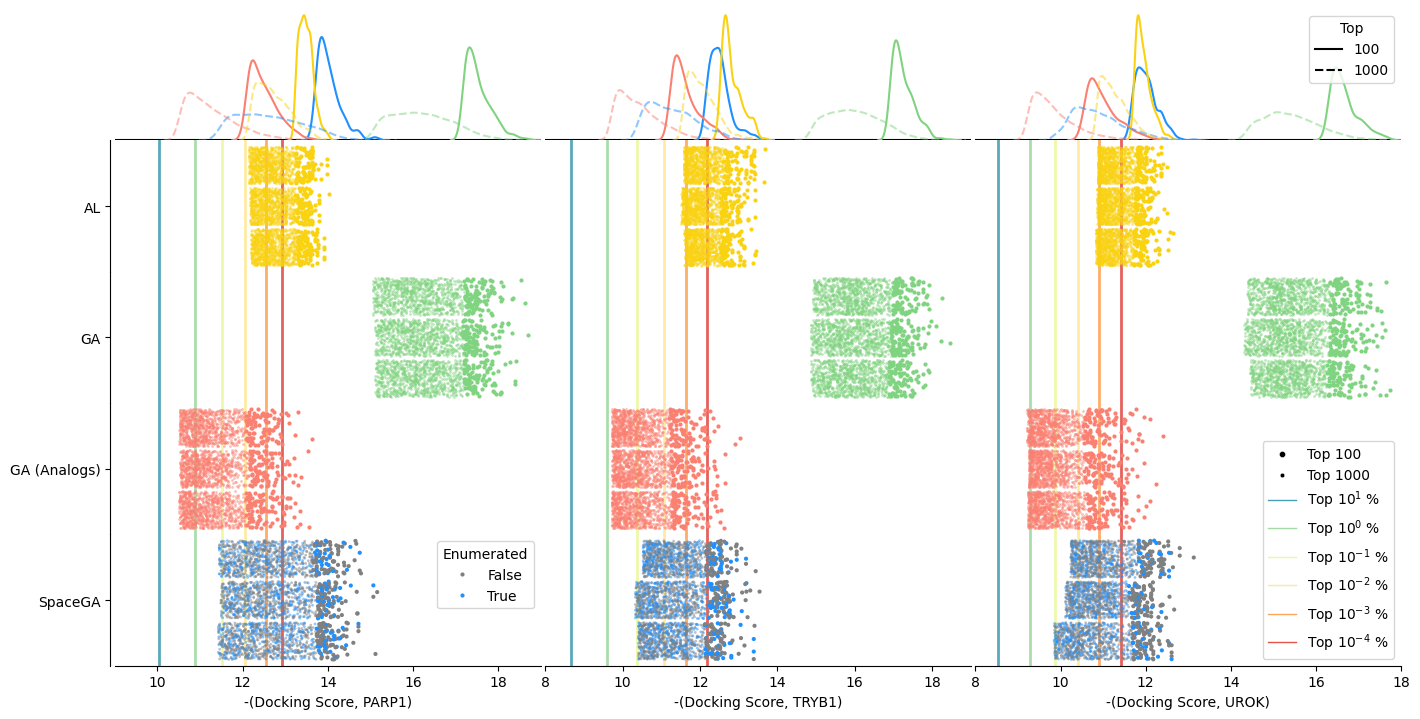

In [6]:
fig, axes = multiplot(n_names, 3, 14, 7)

# Set x-axis limits
plot_settings = {}
for k, protein in enumerate(["PARP1", "TRYB1", "UROK"]):
    plot_settings[protein] = {}
    plot_settings[protein]["xmin"] = xmin = int(dfs[protein].scores.min()) - 1
    plot_settings[protein]["max"] = int(dfs[protein].scores.max()) + 1
    for i in range(n_names+1):
        ax = axes[i, 1 + k]
        ax.set_xlim(plot_settings[protein]["xmin"], plot_settings[protein]["max"])

# y-labels
for k, Method in enumerate(combined.Method.unique()):
    axes[k + 1, 0].set_yticks([1], [Method])

# Density plots
for k, protein in enumerate(["PARP1", "TRYB1", "UROK"]):
    df = dfs[protein]
    ax = axes[0, 1 + k]
    sns.kdeplot(top[protein].sort_values("Method"), x="scores", hue="Method", ax=ax, legend=False, palette=palette)
    sns.kdeplot(df.sort_values("Method"), x="scores", hue="Method", ax=ax, legend=False, palette=palette, alpha=0.5, ls="--")
    

# Strip plots
for k, protein in enumerate(["PARP1", "TRYB1", "UROK"]):
    e = levels[protein]
    df = dfs[protein]
    for i, (Method, subset) in enumerate(df.groupby("Method")):
        subset = subset.sort_values(["scores", "Enumerated"], ascending=False)
        ax = axes[i + 1, k + 1]
        # add frequency lines
        for n in range(6):
            sns.lineplot(x=[e[n], e[n]], y=[-10,10], ax=ax, linewidth=2, estimator=None, c=palette2[n], alpha=0.9)
        subtop = pd.concat([s.tail(900) for r, s in subset.groupby("Rep.")])
        toptop = pd.concat([s.head(100) for r, s in subset.groupby("Rep.")])
        if i != n_names-1: 
            sns.stripplot(data=subtop, x="scores", y="Rep.", s=2, ax=ax, jitter=0.45, c=palette[i], alpha=0.5, legend=False)
            sns.stripplot(data=toptop, x="scores", y="Rep.", s=3, ax=ax, jitter=0.45, c=palette[i], alpha=1, legend=False)
        else: # Bottom row: SpaceGA
            sns.stripplot(data=subtop, x="scores", y="Rep.", s=2, ax=ax, jitter=0.45, hue="Enumerated", palette=["gray", palette[i]], alpha=0.5, legend=False)
            sns.stripplot(data=toptop, x="scores", y="Rep.", s=3, ax=ax, jitter=0.45, hue="Enumerated", palette=["gray", palette[i]], alpha=1, legend=k==0)
            ax.spines['bottom'].set_visible(True),
            ax.set_xlabel(f"-(Docking Score, {protein})")

        ax.set_ylim(-0.6, 2.6)


# Add legends
gs = axes[0, 0].get_gridspec()
# kde plots
legend1 = fig.add_subplot(gs[0, -1])
legend1 = invisible(legend1)
dummy = pd.DataFrame({"x": [0,1], "y": [0,1], "Top": ["100", "1000"]})
sns.lineplot(dummy,x="x", y="y", ax=legend1, legend=True, style="Top", c="k")
# line plots
legend2 = fig.add_subplot(gs[3:, -1])
legend2 = invisible(legend2)
sns.scatterplot(x=[20], y=[0], s=20, label="Top 100", c="k", ax=legend2)
sns.scatterplot(x=[20], y=[0], s=10, label="Top 1000", c="k", alpha=1, ax=legend2)
for n in range(6):
    f = "{" + str(-n-1+2) + "}"
    sns.lineplot(x=[0], y=[20], ax=legend2, linewidth=1, estimator=None, c=palette2[n], label=f'Top $10^{f}$ %')
legend2.legend(loc='lower right')

fig.tight_layout(pad=0.0)
plt.savefig("../figures/scores.pdf")